# Imports

In [1]:
import numpy as np
import sympy as sy
import re
import csv

import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams
import scipy.constants as pc
from sympy import *
from math import log10, floor
from math import *
import math

from scipy.optimize import curve_fit
from scipy.optimize import minimize

rcParams['font.size'] = 15
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams["xtick.minor.size"] =  4
rcParams["ytick.minor.size"] =  4
rcParams["xtick.minor.visible"] =  True
rcParams["ytick.minor.visible"] =  True

# Selfcoded functions

In [2]:
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)], zMaxArray[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

# Pockelseffekt


### DATEN EINLESEN


In [3]:
# importing pandas
import pandas as pd

# Daten als Tabelle einlesen
data = pd.read_csv('saegezahn_HM1508.csv', sep=',', header=None)

# Erste Zeile / Header entfernen
data = data.drop([0], axis=0)

# Einzelne Datenreihen für die Zeit und die beiden Channels in numpy float arrays umwandeln
time_long = data[0].to_numpy().astype(float) 
channelA = data[1].to_numpy().astype(float) 
channelB = data[2].to_numpy().astype(float) 

# Jeden zweiten Wert entfernen, da diese Fehlerhaft sind
time = time_long[::2]   
channelA = channelA[::2]
channelB = channelB[::2]

#load data
df = pd.read_csv("damp1503_neu_HM1508.csv")
df_2 = pd.read_csv("ch2_auf_ch1_HM1508.csv")

# Convert DataFrame columns to NumPy arrays
channelA_damp = df['CH B'].to_numpy()
channelB_damp = df['CH A'].to_numpy() 
time_array = df['Time'].to_numpy()



### DÄMPFUNG BERECHNEN

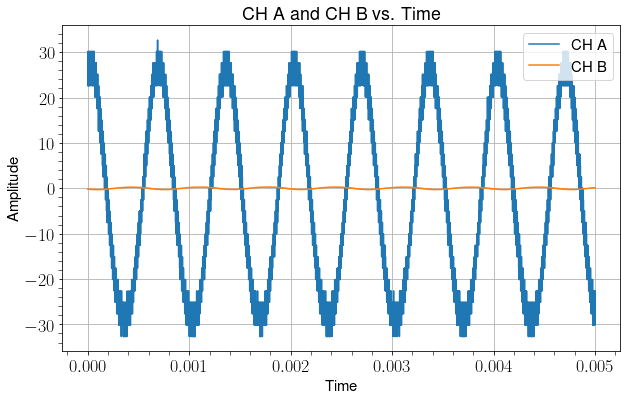

In [4]:
#Plot daempfung
plt.figure(figsize=(10, 6))  
plt.plot(time_array, channelA_damp, label='CH A',marker=None)
plt.plot(time_array, channelB_damp, label='CH B',marker=None)

#labels und legend
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# show plot
plt.grid(True)
plt.title('CH A and CH B vs. Time')
plt.show()

Maximalwert ohne Dämpfung: 27.931420026160605 pm 0.11816728037563674
Maximalwert mit Dämpfung: 0.2629699476871336 pm 0.0005694691434085768
Dämpfung: 106.21525490582593
Fehler auf die Dämpfung 0.004752649790179761
0.5048039089420635


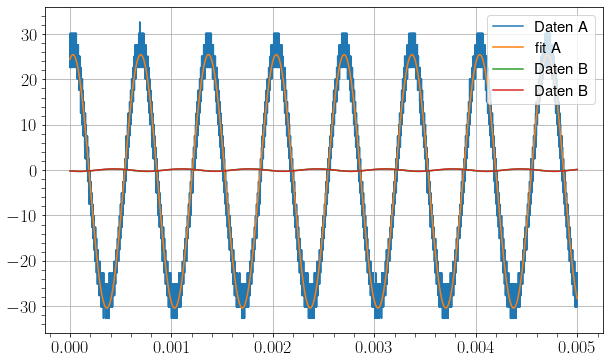

In [5]:
def fit_sin(p0,x,y):
    fit = curve_fit(my_sin, x, y, p0=p0)
    data_fit = my_sin(x, *fit[0])
    return data_fit

def amp_and_err(p0,x,y):
    params, covariance = curve_fit(my_sin, x, y, p0=p0)
    amplitude = params[1]
    amplitude_error = np.sqrt(covariance[1, 1])
    return amplitude, amplitude_error

# Funktion die wir fitten
def my_sin(x, freq, amplitude, phase, offset):
    return np.sin(x * freq + phase) * amplitude + offset

# Anfangswerte für den fit (geraten)   
#p0=[guess_freq, guess_amplitude, guess_phase, guess_offset]
p0_dampA = [58000/(2*pi), 9, 1.5, 0]
p0_dampB = [58000/(2*pi), 0.25, 3.5, 0]

# Plots
plt.figure(figsize=(10, 6))

plt.plot(time_array,channelA_damp,label="Daten A")
# plt.plot(time_array,my_sin(time_array, *p0_dampA),label="guess A")
plt.plot(time_array,fit_sin(p0_dampA,time_array,channelA_damp),label="fit A")

plt.plot(time_array,channelB_damp,label="Daten B")
# plt.plot(time_array,my_sin(time_array, *p0_dampB),label="guess B")
plt.plot(time_array,fit_sin(p0_dampB,time_array,channelB_damp),label="Daten B")

plt.legend()

# Amplituden
amp_damp_A = np.abs(amp_and_err(p0_dampA,time_array,channelA_damp)[0])
amp_damp_B = np.abs(amp_and_err(p0_dampB,time_array,channelB_damp)[0])

amp_damp_A_err = amp_and_err(p0_dampA,time_array,channelA_damp)[1]
amp_damp_B_err = amp_and_err(p0_dampB,time_array,channelB_damp)[1]

#printing
print("Maximalwert ohne Dämpfung:",amp_damp_A,"pm",amp_damp_A_err)
print("Maximalwert mit Dämpfung:",amp_damp_B,"pm",amp_damp_B_err)
print("Dämpfung:",amp_damp_A/amp_damp_B)
print("Fehler auf die Dämpfung",einfachGaussMult(np.array([amp_damp_A_err,amp_damp_B_err]),
                                np.array([amp_damp_A,amp_damp_B]) , np.array([1,-1])))
print(amp_damp_A/amp_damp_B*np.sqrt((amp_damp_A_err/amp_damp_A)**2+(amp_damp_B_err/amp_damp_B)**2))

### DATEN VERARBEITEN & FIT BERECHNEN

In [6]:
# Eigene Notizen:

# Anfangs und Endwert des Signals bestimmen
timeWindow = time[int(len(time)*11.5/29):int(len(time)*19.3/29)]  
channelBWindow = channelB[int(len(channelB)*11.5/29):int(len(channelB)*19.3/29)]  

# Abgeflachten Peaks aus Daten nehmen
timeWindowPeakAdjusted = timeWindow[109:]
timeWindowPeakAdjusted = np.concatenate((timeWindow[:30], timeWindowPeakAdjusted))
channelBWindowPeakAdjusted = channelBWindow[109:]
channelBWindowPeakAdjusted = np.concatenate((channelBWindow[:30], channelBWindowPeakAdjusted))



# Überprüfung Maximalwert um den Anfangswert raten
print(max(channelBWindowPeakAdjusted))

# Anfangswerte für den fit (geraten)
guess_freq = 2940/(2*pi)
guess_amplitude = 3.10464
guess_phase = 0.15
guess_offset = -1
p0=[guess_freq, guess_amplitude,
    guess_phase, guess_offset]

# Funktion die wir fitten
def my_sin(x, freq, amplitude, phase, offset):
    return np.sin(x * freq + phase) * amplitude + offset

# Fit ausführen mit scipy curvefit
fit = curve_fit(my_sin, timeWindowPeakAdjusted, channelBWindowPeakAdjusted, p0=p0)

# Daten die mithilfe der optimisierten Parameter erzeugt wurden
data_fit = my_sin(timeWindow, *fit[0])

print(max(data_fit))

3.10464
3.344379787505815


### DATEN PLOTTEN

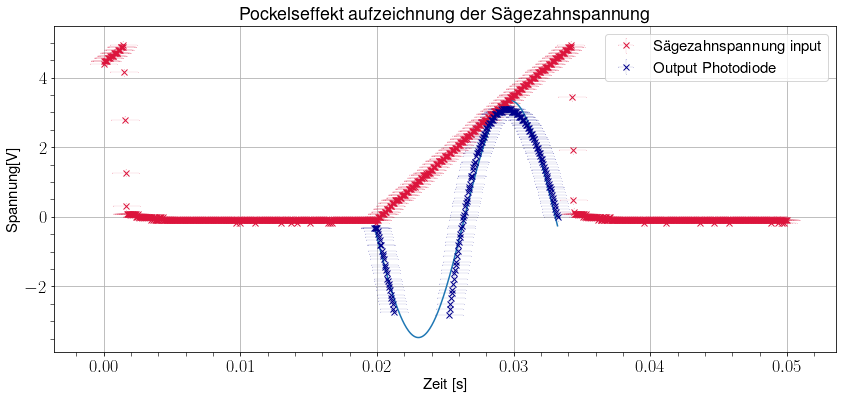

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

# Daten Aufzeichnen
ax.errorbar(time, channelA, xerr=0.001, yerr=0.1, capsize=0.1, elinewidth=.1, fmt='x', color="crimson", label=r'Sägezahnspannung input')
ax.errorbar(timeWindowPeakAdjusted, channelBWindowPeakAdjusted, xerr=0.001, yerr=0.1, capsize=0.1, elinewidth=.1, fmt='x', color="darkblue", label=r'Output Photodiode')

# Fitkurve aufzeichnen
ax.plot(timeWindow, data_fit)

# Titel & Achsenlabels festlegen
ax.set(title=r'Pockelseffekt aufzeichnung der Sägezahnspannung')
ax.set(xlabel=r'Zeit [s]', ylabel=r'Spannung[V]')


ax.legend()
#fig.savefig("Pockel1.pdf")

Highest point: Value = 3.344379787505815, Index = 199
Lowest point: Value = -3.46902891172782, Index = 64
ind hoch 0.029965 ind tief 0.0232116
V hoch damp 3.4906251609360455 V tief damp 1.0836495182064843
2.406975642729561
V hoch und 370.7576412495117
V tied und 115.10010980487718

V lambda halbe 255.65753144463454
Result: 255.66
Uncertainty: 6.51


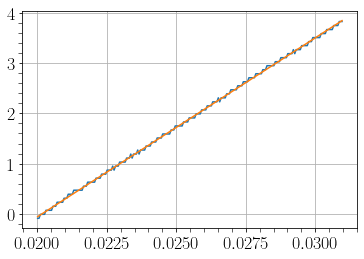

In [8]:
#ausgleichsgerade für sägezahan

start_point = 0.02 
end_point = 0.031  

# Find the indices corresponding to the selected portion
start_idx = np.where(time >= start_point)[0][0]
end_idx = np.where(time >= end_point)[0][0]

# Extract the selected portion of the signal
x_selected = time[start_idx:end_idx]
y_selected = channelA[start_idx:end_idx]

plt.plot(x_selected, y_selected)

#lin reg y = A + Bx

A = bestA(x_selected, y_selected)
B = bestB(x_selected, y_selected)

plt.plot(x_selected, A + x_selected * B)
lin_reg_säg = A + x_selected * B




# Index hoch und tiefpunkt finden
highest_idx = np.argmax(data_fit)
lowest_idx = np.argmin(data_fit)

# Werte and diesen Punkten von der Sägezahn Funktion
highest_value = data_fit[highest_idx]
lowest_value = data_fit[lowest_idx]

print(f"Highest point: Value = {highest_value}, Index = {highest_idx}")
print(f"Lowest point: Value = {lowest_value}, Index = {lowest_idx}")

print("ind hoch",x_selected[199],"ind tief",x_selected[64])

print("V hoch damp",A + x_selected[199] * B, "V tief damp", A + x_selected[64] * B)
print((A + x_selected[199] * B)-(A + x_selected[64] * B))

print("V hoch und",(A + x_selected[199] * B)*amp_damp_A/amp_damp_B  )
print("V tied und",(amp_damp_A/amp_damp_B) * (A + x_selected[64] * B))
print()
UlamhalbSaeg = (A + x_selected[199] * B)*amp_damp_A/amp_damp_B - (amp_damp_A/amp_damp_B) * (A + x_selected[64] * B)

print("V lambda halbe",UlamhalbSaeg)

def multiply_with_uncertainty(x, delta_x, y, delta_y):
    z = x * y
    delta_z = abs(z) * ((delta_x / abs(x)) + (delta_y / abs(y)))
    return z, delta_z

x = (amp_damp_A/amp_damp_B)
delta_x = 0.5
y = (A + x_selected[199] * B)-(A + x_selected[64] * B)
delta_y = 0.05

result, uncertainty = multiply_with_uncertainty(x, delta_x, y, delta_y)

print(f"Ergebnis: {result:.2f}")
print(f"Fehler: {uncertainty:.2f}")



### Optischer Koeffiziet bestimmen

In [9]:
def propagate_division_error(A, delta_A, B, delta_B):
    C = A/B
    delta_C = abs(C) * math.sqrt((delta_A / A)**2 + (delta_B / B)**2)
    return delta_C

def elektroop_koeff(U_lamhalb):
    return VerrechnungsFaktor /  U_lamhalb

ULamhalb_1 = UlamhalbSaeg
ULamhalb_2 = 248
del1Err = 6.51
del2Err = 4


n_1 = 1.522
n_3 = 1.477
wl = 632.8 * 10**(-9)
d = 0.0024
l = 0.02

VerrechnungsFaktor = wl * d/(4 * l) * (1/2*(1/n_1**2 + 1/n_3**2))**(3/2)

print("r_41,neg:",elektroop_koeff(ULamhalb_1),"pm:",
      propagate_division_error(VerrechnungsFaktor, 0, ULamhalb_1, del1Err))
print("r_41,pos:",elektroop_koeff(ULamhalb_2),"pm",
      propagate_division_error(VerrechnungsFaktor, 0, ULamhalb_2, del2Err))


r_41,neg: 2.2045997646653304e-11 pm: 5.613738185952629e-13
r_41,pos: 2.2726715066845188e-11 pm 3.665599204329869e-13


### Peaks für den zweiten Versuchsteil berechnen

In [10]:
positivePeaks = [86.037, -73.964] # mV
positiveDiff = positivePeaks[0]-positivePeaks[1]
posSpannung = 125.8 # V
posSpannungErrSys = 0.1 #V
posSpannungErrStat = 2 #V 
print(positiveDiff)

negativePeaks = [92.036, -79.964] # mV
negativeDiff = negativePeaks[0]-negativePeaks[1]
posSpannung = 123.0 # V
posSpannungErrSys = 0.1 #V
posSpannungErrStat = 2 #V
print(negativeDiff)

160.001
172.0


# Faraday Effekt


### DATEN EINSCHREIBEN


In [11]:
# Alle Daten aus Laborheft
stromStärke = np.arange(-5,5.5, 0.5) # [A]
stromStärkeErrSys = 0.01 # [A]

winkelDunkel = np.array([-12.2,-10.9,-9.7,-8.3,-7,-5.8,-4.4,-3.1,-1.9,-0.6,
                         0.6,2.2,3.4,4.3,6.0,7.2,8.5,9.7,11.0,12.4,13.4]) # [°]
winkelDunkelErrStat = 0.5 # [°]

winkelHell = np.array([72.7, 68.1, 76., 75.3, 78.9, 81.3, 83, 85.7, 84.9, 86.4, 88.6, 
                       91.3, 93.7, 90.0, 93.5, 94.6, 97.0, 99.6, 103.2, 105.9, 107.8])
winkelHellErrStat = 4 # [°]
winkelErrSys = 0.1    # [°]

winkelDunkelErr = np.sqrt(winkelDunkelErrStat**2+winkelErrSys**2)
winkelHellErr = np.sqrt(winkelHellErrStat**2+winkelErrSys**2)


winkelMaxDunkelAussen = 10.4 # [°]
winkelMaxDunkelInnen = -0.9  # [°]
winkelMaxDunkelErr = 0.5


# Der zweiEpsilon Winkel berechnet sich aus dem Unterschied zwischen der beiden maximal dunklen Winkeln
zweiEpsilon = winkelMaxDunkelAussen-winkelMaxDunkelInnen


In [12]:
# uncertanty function
def calculate_uncertainties(x, y, delta_x, delta_y):
    N = len(x)
    A_fit = bestA(x, y)
    B_fit = bestB(x, y)
    
    delta_A = delta_y * np.sqrt(np.sum(x**2) / (N * (N * np.sum(x**2) - np.sum(x)**2)))
    delta_B = delta_y * np.sqrt(N / (N * np.sum(x**2) - np.sum(x)**2))
    
    return A_fit, B_fit, delta_A, delta_B



### DATEN VERARBEITEN & FIT BERECHNEN

In [13]:
# Berechnung der Bestwerte und Standardunsicherheiten der Ausgleichsgerade für die dunklen Daten
bDunkel = bestA(stromStärke, winkelDunkel)
mDunkel = bestB(stromStärke, winkelDunkel)
bDunkelErr = calculate_uncertainties(stromStärke, winkelDunkel, stromStärkeErrSys, winkelDunkelErr)[2]
mDunkelErr = calculate_uncertainties(stromStärke, winkelDunkel, stromStärkeErrSys, winkelDunkelErr)[3]

# Berechnung der Bestwerte und Standardunsicherheiten der Ausgleichsgerade für die hellen Daten
bHell = bestA(stromStärke, winkelHell)
mHell = bestB(stromStärke, winkelHell)
bHellErr = calculate_uncertainties(stromStärke, winkelHell, stromStärkeErrSys, winkelHellErr)[2]
mHellErr = calculate_uncertainties(stromStärke, winkelHell, stromStärkeErrSys, winkelHellErr)[3]

# Ausgabe der Bestwerte und Standardunsicherheiten der Ausgleichsgerade für die dunklen Daten
print("Dunkel für m*x+b:\n")
print('('+str(mDunkel)+'+-'+str(mDunkelErr)+')*x + '+str(bDunkel)+'+-'+str(bDunkelErr))

# Ausgabe der Bestwerte und Standardunsicherheiten der Ausgleichsgerade für die hellen Daten
print("Hell für m*x+b:\n")
print('('+str(mHell)+'+-'+str(mHellErr)+')*x + '+str(bHell)+'+-'+str(bHellErr))

Dunkel für m*x+b:

(2.577922077922078+-0.03675118162249142)*x + 0.7047619047619054+-0.024281045302822785
Hell für m*x+b:

(3.458181818181819+-0.28839006773609804)*x + 88.45238095238093+-0.19053570498802436


### DATEN PLOTTEN

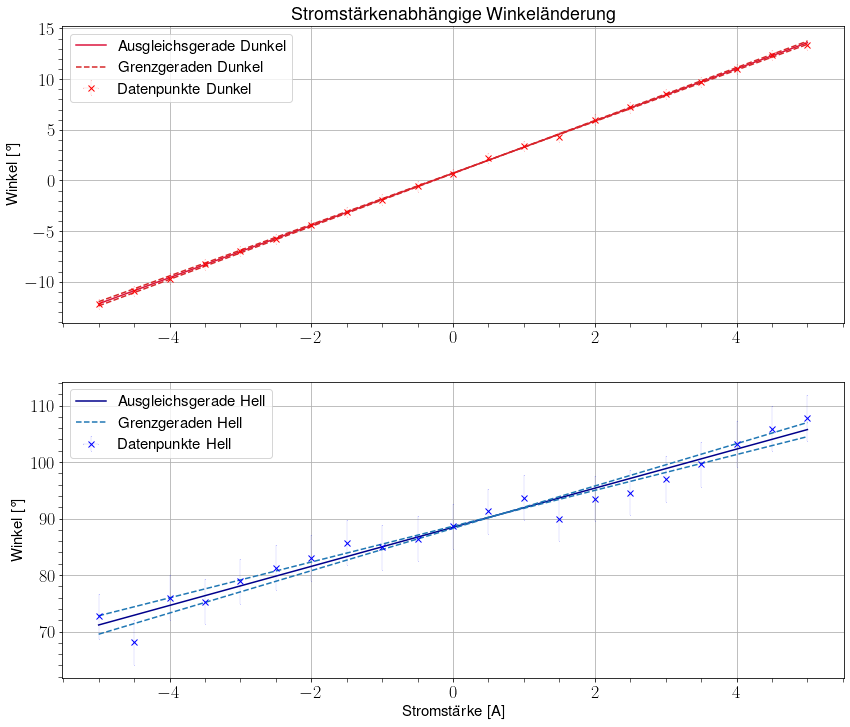

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(14,12))

# Daten Aufzeichnen
ax[0].errorbar(stromStärke, winkelDunkel, xerr=stromStärkeErrSys, yerr=winkelDunkelErr, 
            capsize=0.1, elinewidth=.1, fmt='x', color="red", label=r'Datenpunkte Dunkel')
ax[1].errorbar(stromStärke, winkelHell, xerr=stromStärkeErrSys, yerr=winkelHellErr, 
            capsize=0.1, elinewidth=.1, fmt='x', color="blue", label=r'Datenpunkte Hell')

# Fitkurve aufzeichnen
ax[0].plot(stromStärke, stromStärke*mDunkel+bDunkel, color="crimson", label=r'Ausgleichsgerade Dunkel')
ax[0].plot(stromStärke, stromStärke*(mDunkel+mDunkelErr)+bDunkel-bDunkelErr, color='tab:red', ls='dashed', label=r'Grenzgeraden Dunkel')
ax[0].plot(stromStärke, stromStärke*(mDunkel-mDunkelErr)+bDunkel+bDunkelErr, color='tab:red', ls='dashed')

ax[1].plot(stromStärke, stromStärke*mHell+bHell, color="darkblue", label=r'Ausgleichsgerade Hell')
ax[1].plot(stromStärke, stromStärke*(mHell+mHellErr)+bHell-bHellErr, color='tab:blue', ls='dashed', label=r'Grenzgeraden Hell')
ax[1].plot(stromStärke, stromStärke*(mHell-mHellErr)+bHell+bHellErr, color='tab:blue', ls='dashed')

# Titel & Achsenlabels festlegen
ax[0].set(title=r'Stromstärkenabhängige Winkeländerung')
ax[0].set(xlabel=r'', ylabel=r'Winkel [°]')
ax[1].set(xlabel=r'Stromstärke [A]', ylabel=r'Winkel [°]')


ax[0].legend()
ax[1].legend()
#fig.savefig("Faraday1.pdf")

In [15]:
import sympy as sp

# sp symbols
I, r, theta, z, l, Le, r_1, r_2, N = sp.symbols('I r theta z l Le r_1 r_2 N')

# Werte aus Anleitung
l   = 0.15
Le  = 0.175
r_1 = 0.02/2
r_2 = 0.15/2
N   = 3600

# Define your function
f = (N)/(2*Le*(r_2-r_1))*((Le-z)*sp.log((r_2+sp.sqrt((Le-z)**2+r_2**2))/
                                        (r_1+sp.sqrt((Le-z)**2+r_1**2)))+
                               z*sp.log((r_2+sp.sqrt((Le+z)**2+r_2**2))/
                                        (r_1+sp.sqrt((Le+z)**2+r_1**2))))

#funktion zum testen
f


N*(z*log((r_2 + sqrt(r_2**2 + (Le + z)**2))/(r_1 + sqrt(r_1**2 + (Le + z)**2))) + (Le - z)*log((r_2 + sqrt(r_2**2 + (Le - z)**2))/(r_1 + sqrt(r_1**2 + (Le - z)**2))))/(2*Le*(-r_1 + r_2))

In [16]:
from scipy.integrate import quad

def integrand(z, l, Le,r_1,r_2,N): #Sehr kompliziert
    return (N)/(2*Le*(r_2-r_1))*((Le-z)*sp.log((r_2+sp.sqrt((Le-z)**2+r_2**2))/
                                               (r_1+sp.sqrt((Le-z)**2+r_1**2)))+
                                      z*sp.log((r_2+sp.sqrt((z)**2+r_2**2))/
                                               (r_1+sp.sqrt((z)**2+r_1**2))))



I = quad(integrand, (Le-l)/2, (Le+l)/2, args=(l,Le,r_1,r_2,N))
int_erg = I[0]
I

(2554.847913820812, 1.4101865091496198e-10)

In [17]:
#Ungenaue Funktion
def integrand(z, l, Le,r_1,r_2,N):
    return N/Le

I = quad(integrand, (Le-l)/2, (Le+l)/2, args=(l,Le,r_1,r_2,N))
I

(3085.714285714286, 3.425831047414769e-11)

In [18]:
#Verdet Konstante berechnen
def arcm_oe(deg_amp):
    return 0.7957747151 * 60 * deg_amp 

def propagate_division_error(A, delta_A, B, delta_B):
    if B == 0:
        raise ValueError("Division by zero is not allowed.")
    C = A / B
    
    delta_C = abs(C) * math.sqrt((delta_A / A)**2 + (delta_B / B)**2)
    
    return C, delta_C


print("Verdet dunkel in°/A",mDunkel/int_erg,"pm",propagate_division_error(mDunkel,mDunkelErr,int_erg,0)[1])
print("Verdet dunkel in arcmin/Oe",arcm_oe(mDunkel/int_erg),"pm",arcm_oe(propagate_division_error(mDunkel,mDunkelErr,int_erg,0)[1]))

print("Verdet hell in°/A",mHell/int_erg,"pm",
      propagate_division_error(mHell,mHellErr,int_erg,0)[1])
print("Verdet hell in arcmin/Oe",arcm_oe(mHell/int_erg),"pm",
      arcm_oe(propagate_division_error(mHell,mHellErr,int_erg,0)[1]))


Verdet dunkel in°/A 0.0010090315215932984 pm 1.4384880377293962e-05
Verdet dunkel in arcmin/Oe 0.04817770629736959 pm 0.0006868274450393209
Verdet hell in°/A 0.0013535763907801689 pm 0.00011287954409184635
Verdet hell in arcmin/Oe 0.0646285120043505 pm 0.005389601222418415
